<a href="https://colab.research.google.com/github/GoogleCloudPlatform/tensorflow-without-a-phd/blob/master/tensorflow-rnn-tutorial/01_Keras_stateful_RNN_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An stateful RNN model to generate sequences
RNN models can generate long sequences based on past data. This can be used to predict stock markets, temperatures, traffic or sales data based on past patterns. They can also be adapted to [generate text](https://docs.google.com/presentation/d/18MiZndRCOxB7g-TcCl2EZOElS5udVaCuxnGznLnmOlE/pub?slide=id.g139650d17f_0_1185). The quality of the prediction will depend on training data, network architecture, hyperparameters, the distance in time at which you are predicting and so on. But most importantly, it will depend on wether your training data contains examples of the behaviour patterns you are trying to predict.

This is the solution notebook. The corresponding work notebook is [01_Keras_stateful_RNN_playground.ipynb](https://colab.research.google.com/github/GoogleCloudPlatform/tensorflow-without-a-phd/blob/master/tensorflow-rnn-tutorial/01_Keras_stateful_RNN_playground.ipynb)


In [0]:
import math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
tf.enable_eager_execution()
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.13.1


In [0]:
#@title Data formatting and display utilites [RUN ME]

def dumb_minibatch_sequencer(data, batch_size, sequence_size, nb_epochs):
    """
    Divides the data into batches of sequences in the simplest way: sequentially.
    :param data: the training sequence
    :param batch_size: the size of a training minibatch
    :param sequence_size: the unroll size of the RNN
    :param nb_epochs: number of epochs to train on
    :return:
        x: one batch of training sequences
        y: one batch of target sequences, i.e. training sequences shifted by 1
    """
    data_len = data.shape[0]
    nb_batches = data_len // (batch_size * sequence_size)
    rounded_size = nb_batches * batch_size * sequence_size
    xdata = data[:rounded_size]
    ydata = np.roll(data, -1)[:rounded_size]
    xdata = np.reshape(xdata, [nb_batches, batch_size, sequence_size])
    ydata = np.reshape(ydata, [nb_batches, batch_size, sequence_size])

    for epoch in range(nb_epochs):
        for batch in range(nb_batches):
            yield xdata[batch,:,:], ydata[batch,:,:]
            
            
def rnn_minibatch_sequencer(data, batch_size, sequence_size, nb_epochs):
    """
    Divides the data into batches of sequences so that all the sequences in one batch
    continue in the next batch. This is a generator that will keep returning batches
    until the input data has been seen nb_epochs times. Sequences are continued even
    between epochs, apart from one, the one corresponding to the end of data.
    The remainder at the end of data that does not fit in an full batch is ignored.
    :param data: the training sequence
    :param batch_size: the size of a training minibatch
    :param sequence_size: the unroll size of the RNN
    :param nb_epochs: number of epochs to train on
    :return:
        x: one batch of training sequences
        y: one batch of target sequences, i.e. training sequences shifted by 1
    """
    data_len = data.shape[0]
    # using (data_len-1) because we must provide for the sequence shifted by 1 too
    nb_batches = (data_len - 1) // (batch_size * sequence_size)
    assert nb_batches > 0, "Not enough data, even for a single batch. Try using a smaller batch_size."
    rounded_data_len = nb_batches * batch_size * sequence_size
    xdata = np.reshape(data[0:rounded_data_len], [batch_size, nb_batches * sequence_size])
    ydata = np.reshape(data[1:rounded_data_len + 1], [batch_size, nb_batches * sequence_size])

    whole_epochs = math.floor(nb_epochs)
    frac_epoch = nb_epochs - whole_epochs
    last_nb_batch = math.floor(frac_epoch * nb_batches)
    
    for epoch in range(whole_epochs+1):
        for batch in range(nb_batches if epoch < whole_epochs else last_nb_batch):
            x = xdata[:, batch * sequence_size:(batch + 1) * sequence_size]
            y = ydata[:, batch * sequence_size:(batch + 1) * sequence_size]
            x = np.roll(x, -epoch, axis=0)  # to continue the sequence from epoch to epoch (do not reset rnn state!)
            y = np.roll(y, -epoch, axis=0)
            yield x, y
            

plt.rcParams['figure.figsize']=(16.8,6.0)
plt.rcParams['axes.grid']=True
plt.rcParams['axes.linewidth']=0
plt.rcParams['grid.color']='#DDDDDD'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['xtick.major.size']=0
plt.rcParams['ytick.major.size']=0
plt.rcParams['axes.titlesize']=15.0


def display_lr(lr_schedule, nb_epochs):
  x = np.arange(nb_epochs)
  y = [lr_schedule(i) for i in x]
  plt.figure(figsize=(9,5))
  plt.plot(x,y)
  plt.title("Learning rate schedule\nmax={:.2e}, min={:.2e}".format(np.max(y), np.min(y)),
            y=0.85)
  plt.show()
  
def display_loss(history, full_history, nb_epochs):
  plt.figure()
  plt.plot(np.arange(0, len(full_history['loss']))/steps_per_epoch, full_history['loss'], label='detailed loss')
  plt.plot(np.arange(1, nb_epochs+1), history['loss'], color='red', linewidth=3, label='average loss per epoch')
  plt.ylim(0,3*max(history['loss'][1:]))
  plt.xlabel('EPOCH')
  plt.ylabel('LOSS')
  plt.xlim(0, nb_epochs+0.5)
  plt.legend()
  for epoch in range(nb_epochs//2+1):
    plt.gca().axvspan(2*epoch, 2*epoch+1, alpha=0.05, color='grey')
  plt.show()

def picture_this_7(features):
    subplot = 231
    for i in range(6):
        plt.subplot(subplot)
        plt.plot(features[i])
        subplot += 1
    plt.show()
    
def picture_this_8(data, prime_data, results, offset, primelen, runlen, rmselen):
    disp_data = data[offset:offset+primelen+runlen]
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.subplot(211)
    plt.xlim(0, disp_data.shape[0])
    plt.text(primelen,2.5,"DATA |", color=colors[1], horizontalalignment="right")
    plt.text(primelen,2.5,"| PREDICTED", color=colors[0], horizontalalignment="left")
    displayresults = np.ma.array(np.concatenate((np.zeros([primelen]), results)))
    displayresults = np.ma.masked_where(displayresults == 0, displayresults)
    plt.plot(displayresults)
    displaydata = np.ma.array(np.concatenate((prime_data, np.zeros([runlen]))))
    displaydata = np.ma.masked_where(displaydata == 0, displaydata)
    plt.plot(displaydata)
    plt.subplot(212)
    plt.xlim(0, disp_data.shape[0])
    plt.text(primelen,2.5,"DATA |", color=colors[1], horizontalalignment="right")
    plt.text(primelen,2.5,"| +PREDICTED", color=colors[0], horizontalalignment="left")
    plt.plot(displayresults)
    plt.plot(disp_data)
    plt.axvspan(primelen, primelen+rmselen, color='grey', alpha=0.1, ymin=0.05, ymax=0.95)
    plt.show()

    rmse = math.sqrt(np.mean((data[offset+primelen:offset+primelen+rmselen] - results[:rmselen])**2))
    print("RMSE on {} predictions (shaded area): {}".format(rmselen, rmse))

## Generate fake dataset

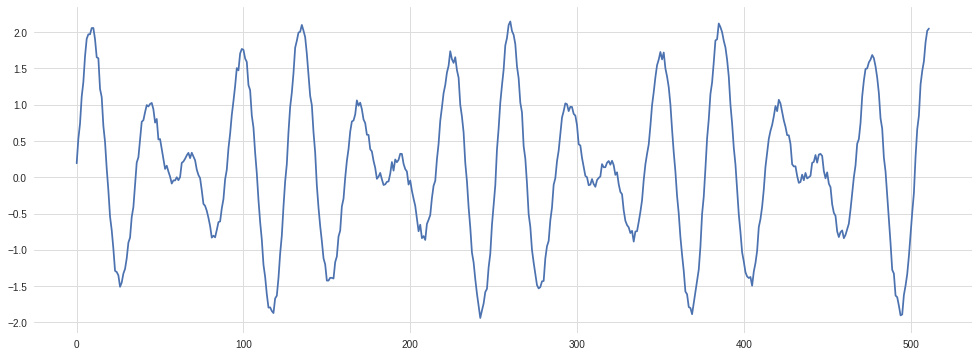

In [0]:
WAVEFORM_SELECT = 0# select 0, 1 or 2

def create_time_series(datalen):
    # good waveforms
    frequencies = [(0.2, 0.15), (0.35, 0.3), (0.6, 0.55)]
    freq1, freq2 = frequencies[WAVEFORM_SELECT]
    noise = [np.random.random()*0.1 for i in range(datalen)]
    x1 = np.sin(np.arange(0,datalen) * freq1)  + noise
    x2 = np.sin(np.arange(0,datalen) * freq2)  + noise
    x = x1 + x2
    return x.astype(np.float32)

DATA_LEN = 1024*128+1
data = create_time_series(DATA_LEN)
plt.plot(data[:512])
plt.show()

## Hyperparameters

In [0]:
RNN_CELLSIZE = 80 # size of the RNN cells
SEQLEN = 32       # unrolled sequence length
BATCHSIZE = 30    # mini-batch size
DROPOUT = 0.3     # dropout regularization: probability of neurons being dropped. Should be between 0 and 0.5

## Visualize training sequences
This is what the neural network will see during training.

Features shape: (30, 32)
Labels shape: (30, 32)
Excerpt from first batch:


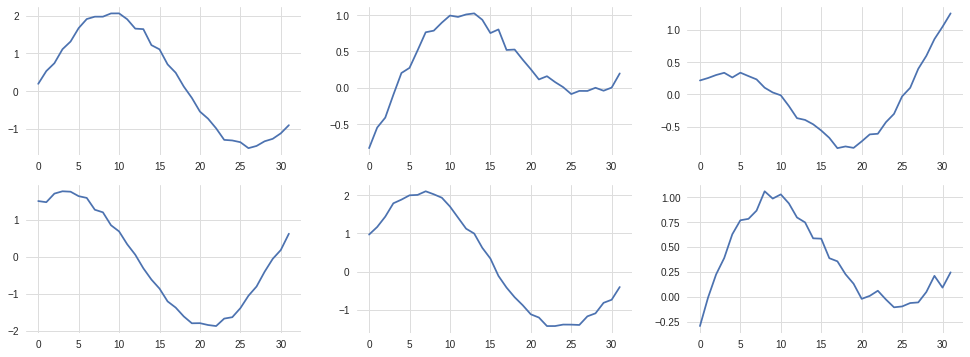

In [0]:
# The function dumb_minibatch_sequencer splits the data into batches of sequences sequentially.
for features, labels in dumb_minibatch_sequencer(data, BATCHSIZE, SEQLEN, nb_epochs=1):
    break
print("Features shape: " + str(features.shape))
print("Labels shape: " + str(labels.shape))
print("Excerpt from first batch:")

picture_this_7(features)

## The model

![deep RNN schematic](https://googlecloudplatform.github.io/tensorflow-without-a-phd/images/RNN1.svg)
<div style="text-align: right; font-family: monospace">
  X shape [BATCHSIZE, SEQLEN, 1]<br/>
  Y shape [BATCHSIZE, SEQLEN, 1]<br/>
  H shape [BATCHSIZE, RNN_CELLSIZE*NLAYERS]
</div>
In Keras layers, the batch dimension is implicit ! For a shape of [BATCHSIZE, SEQLEN, 1], you write [SEQLEN, 1]. In pure Tensorflow however, this is NOT the case.

In [0]:
def keras_model(batchsize, seqlen):
  l = tf.keras.layers  # syntax shortcut

  model = tf.keras.Sequential([
    l.Reshape([seqlen, 1], input_shape=[seqlen,], batch_size=batchsize), # [BATCHSIZE, SEQLEN, 1] is necessary for RNN model
    l.GRU(RNN_CELLSIZE, stateful=True, return_sequences=True), # output shape [BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    l.GRU(RNN_CELLSIZE, stateful=True, return_sequences=True), # output shape [BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    l.TimeDistributed(l.Dense(1)), # output shape [BATCHSIZE, SEQLEN, 1]
    l.Reshape([seqlen,])           # output shape [BATCHSIZE, SEQLEN]
  ])
  
  # keras does not have a pre-defined metric for Root Mean Square Error. Let's define one.
  def rmse(y_true, y_pred): # Root Mean Squared Error
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

  # to finalize the model, specify the loss, the optimizer and metrics
  model.compile(
     loss = 'mean_squared_error',
     optimizer = 'adam',
     metrics = [rmse])
  
  return model

In [0]:
# Keras model callbacks

# This callback records a per-step loss history instead of the average loss per
# epoch that Keras normally reports. It allows you to see more problems.
class LossHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
      self.history = {'loss': []}
  def on_batch_end(self, batch, logs={}):
      self.history['loss'].append(logs.get('loss'))
      
# This callback resets the RNN state at each epoch
class ResetStateCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, batch, logs={}):
      self.model.reset_states()
      print('reset state')

reset_state = ResetStateCallback()
      
# learning rate decay callback
#def lr_schedule(epoch): return 0.01
def lr_schedule(epoch): return 0.0001 + 0.01 * math.pow(0.8, epoch)
lr_decay = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)

## The training loop

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_20 (Reshape)         (30, 32, 1)               0         
_________________________________________________________________
gru_20 (GRU)                 (30, 32, 80)              19680     
_________________________________________________________________
gru_21 (GRU)                 (30, 32, 80)              38640     
_________________________________________________________________
time_distributed_10 (TimeDis (30, 32, 1)               81        
_________________________________________________________________
reshape_21 (Reshape)         (30, 32)                  0         
Total params: 58,401
Trainable params: 58,401
Non-trainable params: 0
_________________________________________________________________


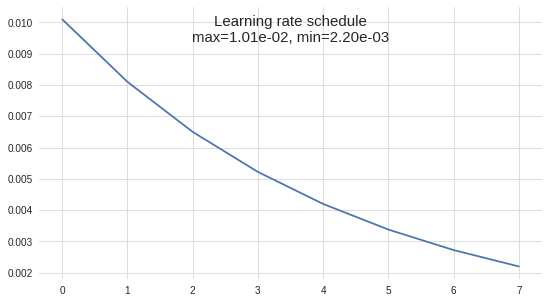

In [0]:
# Execute this cell to reset the model

NB_EPOCHS = 8
model = keras_model(BATCHSIZE, SEQLEN)

# this prints a description of the model
model.summary()

display_lr(lr_schedule, NB_EPOCHS)

In [0]:
# You can re-execute this cell to continue training

steps_per_epoch = (DATA_LEN-1) // SEQLEN // BATCHSIZE
generator = rnn_minibatch_sequencer(data, BATCHSIZE, SEQLEN, NB_EPOCHS)
#generator = dumb_minibatch_sequencer(data, BATCHSIZE, SEQLEN, NB_EPOCHS)
full_history = LossHistory()
history = model.fit_generator(generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=NB_EPOCHS,
                              shuffle=False,
                              callbacks=[lr_decay, full_history]) # Can add reset_state


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0101.
Epoch 1/8
136/136 [==============================] - 11s 81ms/step - loss: 0.0272 - rmse: 0.1222

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0081.
Epoch 2/8
136/136 [==============================] - 8s 59ms/step - loss: 0.0070 - rmse: 0.0834

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0065000000000000014.
Epoch 3/8
136/136 [==============================] - 8s 59ms/step - loss: 0.0064 - rmse: 0.0799

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0052200000000000015.
Epoch 4/8
136/136 [==============================] - 8s 59ms/step - loss: 0.0053 - rmse: 0.0731

Epoch 00005: LearningRateScheduler reducing learning rate to 0.004196000000000001.
Epoch 5/8
136/136 [==============================] - 8s 61ms/step - loss: 0.0049 - rmse: 0.0701

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0033768000000000005.
Epoch 6/8
136/136 [=====================

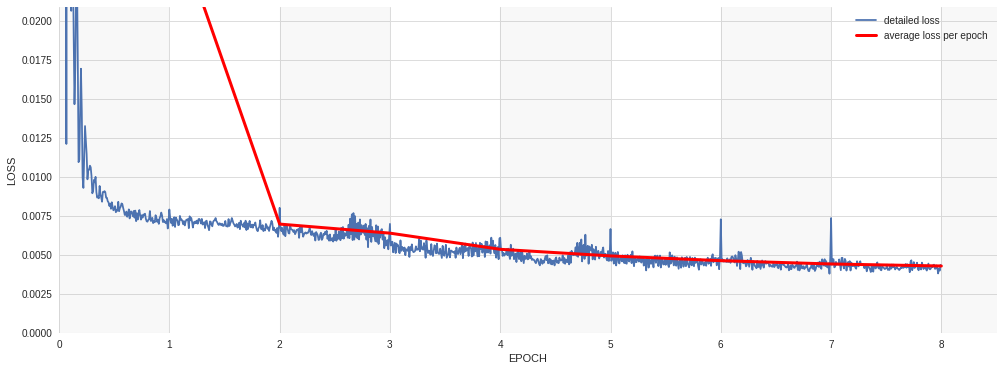

In [0]:
display_loss(history.history, full_history.history, NB_EPOCHS)

## Inference
This is a generative model: run one trained RNN cell in a loop

In [0]:
# Inference from stateful model
def keras_prediction_run(model, prime_data, run_length):
  model.reset_states()
  
  data_len = prime_data.shape[0]
  
  #prime_data = np.expand_dims(prime_data, axis=0) # single batch with everything
  prime_data = np.expand_dims(prime_data, axis=-1) # each sequence is of size 1
  
  # prime the state from data
  for i in range(data_len - 1): # keep last sample to serve as the input sequence for predictions
    model.predict(np.expand_dims(prime_data[i], axis=0))
  
  # prediction run
  results = []
  Yout = prime_data[-1] # start predicting from the last element of the prime_data sequence
  for i in range(run_length+1):
    Yout = model.predict(Yout)
    results.append(Yout[0,0]) # Yout shape is [1,1] i.e one sequence of one element

  return np.array(results)

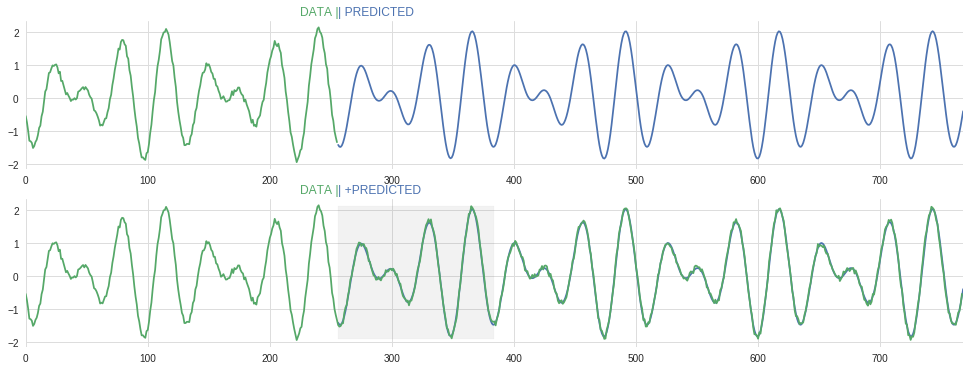

RMSE on 128 predictions (shaded area): 0.05800183856270835


In [0]:
PRIMELEN=256
RUNLEN=512
OFFSET=20
RMSELEN=128

prime_data = data[OFFSET:OFFSET+PRIMELEN]

# For inference, we need a single RNN cell (no unrolling)
# Create a new model that takes a single sequence of a single value (i.e. just one RNN cell)
inference_model = keras_model(1, 1)
# Copy the trained weights into it
inference_model.set_weights(model.get_weights())

results = keras_prediction_run(inference_model, prime_data, RUNLEN)

picture_this_8(data, prime_data, results, OFFSET, PRIMELEN, RUNLEN, RMSELEN)

Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.